In [2]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn import cross_validation
from sklearn.cross_validation import train_test_split
from sklearn import metrics 
import numpy as np
from sklearn.metrics import auc, roc_auc_score
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr
%config InlineBackend.figure_format = 'png'
import time

In [3]:
train = pd.read_csv('../Data/ech_apprentissage.csv', sep=';')
test = pd.read_csv('../Data/ech_test.csv', sep=';')

/home/datageek/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
train.head()

,id,annee_naissance,annee_permis,marque,puis_fiscale,anc_veh,codepostal,energie_veh,kmage_annuel,crm,...,var14,var15,var16,var17,var18,var19,var20,var21,var22,prime_tot_ttc
0,1,1986.0,2006.0,RENAULT,4,1,1034,gpl,2924,68,...,N,1,1,1,27,0,0,0,1,254.75
1,2,1986.0,2006.0,RENAULT,8,2,1034,gpl,11580,50,...,N,2,1,1,28,0,0,0,1,259.89
2,3,1982.0,2001.0,RENAULT,7,2,1034,gpl,7149,95,...,N,3,1,1,29,0,0,0,1,431.65
3,4,1987.0,2006.0,DACIA,5,2,1034,gpl,6526,100,...,N,3,1,1,29,0,0,0,1,577.99
4,5,1994.0,2013.0,CITROEN,4,2,1034,gpl,2872,50,...,N,2,1,4,26,0,1,1,4,222.67


In [5]:
train.shape

(300000, 34)

In [6]:
test.shape

(30000, 33)

In [7]:
all_data = pd.concat((train.loc[:,'annee_naissance':'var22'], test.loc[:,'annee_naissance':'var22']))

In [8]:
all_data.shape

(330000, 32)

### Check Skewness 

In [9]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index
skewness_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #Compute skewness
skewed_feats = skewness_feats[skewness_feats > 0.75]
skewed_feats = skewed_feats.index
all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

In [10]:
# Get dummy variables
##all_data = pd.get_dummies(all_data)
del all_data['codepostal']
#print all_data.dtypes
all_data.shape

(330000, 31)

### Fill NaS

In [11]:
#?pd.DataFrame
#all_data = all_data.fillna(all_data.mean())

In [12]:
#all_data.to_csv('../Data/all_data.csv')


In [13]:
#all_data = pd.read_csv('../Data/all_data.csv')

### Compute the drift

In [14]:

def get_drift(data, labels):
    #print labels.sum()
    data = pd.get_dummies(data)
    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size = 0.5)
    #print y_train.head(10)
    clf = RandomForestClassifier(n_estimators=25)
    clf.fit(X_train, y_train)
    preds = clf.predict(X_test)
    return roc_auc_score(y_test, preds)
    
def compute_drift(d, n_train):
    data = pd.DataFrame(d)
    labels = pd.DataFrame(np.ones(d.shape[0]), columns=['label'])
    labels['label'] = 1
    labels.loc[:n_train, 'label'] = 0
    return get_drift(data, labels['label'])


In [15]:

drifts = pd.DataFrame()
n_train = train.shape[0]
for column in all_data:
    #drifts[column] = compute_drift(all_data[column], n_train)
    


IndentationError: expected an indented block (<ipython-input-15-a8b447c2c8ff>, line 6)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fea9a5a7b90>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fea9809fe90>]], dtype=object)

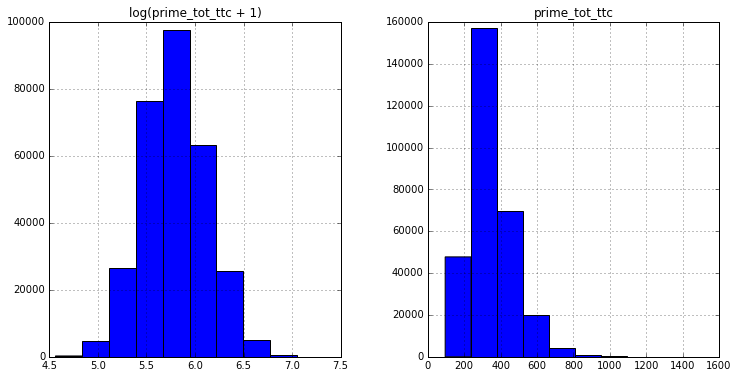

In [16]:
# Check target Skewness
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
prices = pd.DataFrame({'prime_tot_ttc': train['prime_tot_ttc'], 'log(prime_tot_ttc + 1)': np.log1p(train['prime_tot_ttc'])})
prices.hist()

In [17]:
skew(train['prime_tot_ttc'].dropna())

1.2149565636281456

In [18]:
#To try later
train['prime_tot_ttc'] = np.log1p(train['prime_tot_ttc'])

In [19]:
all_data = pd.get_dummies(all_data)

In [20]:
#all_data.isnull().sum()

## First model: XGboostRegressor

In [21]:
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train.prime_tot_ttc

In [22]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLars
from sklearn import cross_validation
import xgboost as xgb

In [23]:
#model_lasso = LassoCV(alphas = [0.0005, 0.001, 0.1, 1]).fit(X_train, y)
model_xgb = xgb.XGBRegressor(n_estimators=360, max_depth=2, learning_rate=0.1) #the params were tuned using xgb.cv
model_xgb.fit(X_train, y)

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=2,
       min_child_weight=1, missing=None, n_estimators=360, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [24]:
preds = model_xgb.predict(X_train)

In [25]:
target_exp = np.expm1(preds)

In [26]:
y_exp = np.expm1(y)

In [27]:
res = np.absolute(target_exp - y_exp)/np.absolute(y_exp)

In [28]:
def getMap(real, pred):
    part1 = (np.absolute(pred - real)/np.absolute(real))
    return np.sum(part1)*100/real.size

In [29]:

map_res = getMap(y_exp, target_exp)
map_res

10.016508183670316

### XgBoost with cross validation

In [30]:
from xgboost.sklearn import XGBRegressor
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search

In [37]:
# https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
def modelfitCV(alg, dtrain, y, predictors,useTrainCV=True, cv_folds=3, early_stopping_rounds=50, metric = 'rmse'):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=y.values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics=metric, early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    return alg

def modelfit(alg, dtrain, y, predictors, metric = 'rsme'):
    #Fit the algorithm on the data
    print "\nModel Fitting"
    #alg.fit(dtrain[predictors], y)
    alg.fit(dtrain[predictors], y,eval_metric=metric)
    print "\nModel Predicting"
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
        
    #Print model report:
    print "\nModel Report"
    print "mean_squared_error : %.4g" % metrics.mean_squared_error(y.values, dtrain_predictions)
    print "MAP Score (Train): %f" % getMap(np.expm1(y), np.expm1(dtrain_predictions))
                    
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

In [38]:
target='prime_tot_ttc'
predictors = [x for x in X_train.columns if x not in [target, 'id']]
#X_train.columns

In [39]:
#Choose all predictors except target & IDcols
start_time = time.time()
xgb1 = XGBRegressor(
 learning_rate =0.1,
 n_estimators=300,
 nthread=4,
 max_depth=5)
alg = modelfitCV(xgb1, X_train, y, predictors)
print("modelfitCV --- %s seconds ---" % (time.time() - start_time))


modelfitCV --- 351.921824932 seconds ---



Model Fitting

Model Predicting

Model Report
MAE : 0.01213
MAP Score (Train): 8.948134
modelfit --- 161.136370897 seconds ---


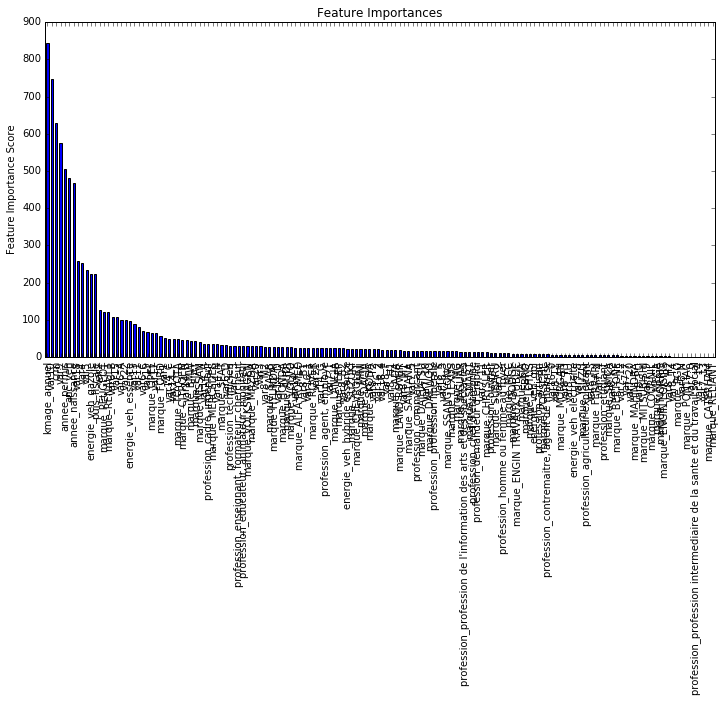

In [40]:
start_time = time.time()
modelfit(alg, X_train, y, predictors, metric = 'map')
print("modelfit --- %s seconds ---" % (time.time() - start_time))

In [57]:
alg

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=300, nthread=4,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

### Starting some tuning 

In [36]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBRegressor( learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8, nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='mean_squared_error',n_jobs=4,iid=False, cv=5)
gsearch1.fit(X_train[predictors],y)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: -0.01579, std: 0.00037, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: -0.01579, std: 0.00037, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: -0.01579, std: 0.00037, params: {'max_depth': 3, 'min_child_weight': 5},
  mean: -0.01383, std: 0.00046, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: -0.01375, std: 0.00042, params: {'max_depth': 5, 'min_child_weight': 3},
  mean: -0.01378, std: 0.00040, params: {'max_depth': 5, 'min_child_weight': 5},
  mean: -0.01290, std: 0.00040, params: {'max_depth': 7, 'min_child_weight': 1},
  mean: -0.01293, std: 0.00044, params: {'max_depth': 7, 'min_child_weight': 3},
  mean: -0.01296, std: 0.00045, params: {'max_depth': 7, 'min_child_weight': 5},
  mean: -0.01251, std: 0.00048, params: {'max_depth': 9, 'min_child_weight': 1},
  mean: -0.01249, std: 0.00045, params: {'max_depth': 9, 'min_child_weight': 3},
  mean: -0.01254, std: 0.00046, params: {'max_depth': 9, 'min_child_weight': 5}],
 {'max_depth': 9, 'min_chil

In [41]:
param_test2 = {
 'max_depth':[9,10,11],
 'min_child_weight':[2,3,4]
}
gsearch1 = GridSearchCV(estimator = XGBRegressor( learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8, nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test2, scoring='mean_squared_error',n_jobs=4,iid=False, cv=5)
gsearch1.fit(X_train[predictors],y)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: -0.01254, std: 0.00047, params: {'max_depth': 9, 'min_child_weight': 2},
  mean: -0.01249, std: 0.00045, params: {'max_depth': 9, 'min_child_weight': 3},
  mean: -0.01252, std: 0.00048, params: {'max_depth': 9, 'min_child_weight': 4},
  mean: -0.01245, std: 0.00051, params: {'max_depth': 10, 'min_child_weight': 2},
  mean: -0.01244, std: 0.00045, params: {'max_depth': 10, 'min_child_weight': 3},
  mean: -0.01244, std: 0.00050, params: {'max_depth': 10, 'min_child_weight': 4},
  mean: -0.01238, std: 0.00049, params: {'max_depth': 11, 'min_child_weight': 2},
  mean: -0.01236, std: 0.00046, params: {'max_depth': 11, 'min_child_weight': 3},
  mean: -0.01236, std: 0.00047, params: {'max_depth': 11, 'min_child_weight': 4}],
 {'max_depth': 11, 'min_child_weight': 4},
 -0.012362166068909081)

In [42]:
param_test2b = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch1 = GridSearchCV(estimator = XGBRegressor( learning_rate =0.1, n_estimators=140, max_depth=9,
 min_child_weight=4, gamma=0, subsample=0.8, colsample_bytree=0.8, nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test2b, scoring='mean_squared_error',n_jobs=4,iid=False, cv=5)
gsearch1.fit(X_train[predictors],y)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: -0.01252, std: 0.00048, params: {'gamma': 0.0},
  mean: -0.01251, std: 0.00049, params: {'gamma': 0.1},
  mean: -0.01256, std: 0.00047, params: {'gamma': 0.2},
  mean: -0.01266, std: 0.00047, params: {'gamma': 0.3},
  mean: -0.01278, std: 0.00049, params: {'gamma': 0.4}],
 {'gamma': 0.1},
 -0.012507688553534424)

In [43]:
#Choose all predictors except target & IDcols
start_time = time.time()
xgb1 = XGBRegressor(
 learning_rate =0.1,
 n_estimators=500, max_depth=11,
 min_child_weight=4, gamma=0, 
 subsample=0.8, colsample_bytree=0.8, 
 nthread=4, scale_pos_weight=1, 
 seed=27)
alg = modelfitCV(xgb1, X_train, y, predictors)
print("modelfitCV --- %s seconds ---" % (time.time() - start_time))

modelfitCV --- 1640.04869795 seconds ---



Model Fitting

Model Predicting

Model Report
MAE : 0.0056
MAP Score (Train): 5.917135
modelfit --- 820.661394835 seconds ---


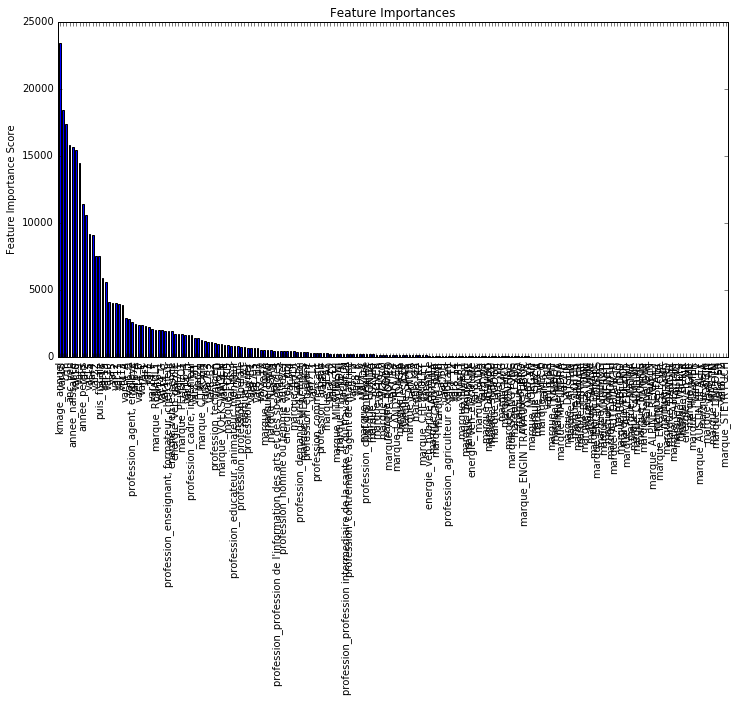

In [44]:
start_time = time.time()
modelfit(alg, X_train, y, predictors, metric = 'map')
print("modelfit --- %s seconds ---" % (time.time() - start_time))